In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Define the dataset path (update if needed)
dataset_path = "workoutfitness-video"

# Select an exercise category (e.g., "push-up")
exercise = "lateral raise"

# List videos in that category
video_files = os.listdir(os.path.join(dataset_path, exercise))
print("Available videos:", video_files)

# Select one video to test
test_video = os.path.join(dataset_path, exercise, video_files[0])
print(f"Testing video: {test_video}")

Available videos: ['lateral raise_1.MOV', 'lateral raise_10.mp4', 'lateral raise_11.mp4', 'lateral raise_12.mp4', 'lateral raise_13.mp4', 'lateral raise_14.mp4', 'lateral raise_15.mp4', 'lateral raise_16.mp4', 'lateral raise_17.mp4', 'lateral raise_18.mp4', 'lateral raise_19.mp4', 'lateral raise_2.MOV', 'lateral raise_20.mp4', 'lateral raise_21.mp4', 'lateral raise_22.mp4', 'lateral raise_23.mp4', 'lateral raise_24.mp4', 'lateral raise_25.mp4', 'lateral raise_26.mp4', 'lateral raise_27.mp4', 'lateral raise_28.mp4', 'lateral raise_29.mp4', 'lateral raise_3.MOV', 'lateral raise_30.mp4', 'lateral raise_31.mp4', 'lateral raise_32.mp4', 'lateral raise_33.mp4', 'lateral raise_34.mp4', 'lateral raise_35.mp4', 'lateral raise_36.mp4', 'lateral raise_37.mp4', 'lateral raise_4.MOV', 'lateral raise_5.MOV', 'lateral raise_6.MOV', 'lateral raise_7.mp4', 'lateral raise_8.mp4', 'lateral raise_9.mp4']
Testing video: workoutfitness-video\lateral raise\lateral raise_1.MOV


In [3]:
# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=False, model_complexity=1, smooth_landmarks=True)

In [4]:
def extract_full_video_keypoints(video_path, label, frame_skip=5):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    keypoints_data = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break  # Exit if video ends

        frame_count += 1
        if frame_count % frame_skip != 0:  # Process every 5th frame
            continue

        # Convert frame to RGB (MediaPipe requires RGB)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Perform Pose Estimation
        results = pose.process(frame_rgb)

        # Extract keypoints if detected
        if results.pose_landmarks:
            keypoints = []
            for lm in results.pose_landmarks.landmark:
                keypoints.append(lm.x)  # X-coordinate (normalized)
                keypoints.append(lm.y)  # Y-coordinate (normalized)
                keypoints.append(lm.z)  # Depth coordinate

            keypoints.append(frame_count)  # Add frame number for sequence learning
            keypoints.append(label)  # Append exercise label
            keypoints_data.append(keypoints)

    cap.release()
    return keypoints_data

In [5]:
# Extract keypoints from test video
test_keypoints = extract_full_video_keypoints(test_video, exercise)

# Convert to DataFrame
columns = [f"x_{i}" for i in range(33)] + [f"y_{i}" for i in range(33)] + [f"z_{i}" for i in range(33)] + ["frame_number", "label"]
df_test = pd.DataFrame(test_keypoints, columns=columns)

# Save to CSV (optional)
df_test.to_csv("test_fitness_keypoints.csv", index=False)
print(f"Extracted {len(df_test)} frames. Data saved to 'test_fitness_keypoints.csv'.")


Extracted 84 frames. Data saved to 'test_fitness_keypoints.csv'.


In [6]:
df_test.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,z_25,z_26,z_27,z_28,z_29,z_30,z_31,z_32,frame_number,label
0,0.484823,0.220364,-0.443042,0.497539,0.193044,-0.407915,0.504305,0.194358,-0.408095,0.512028,...,1.603640,0.263733,0.524336,1.652806,0.135816,0.448690,1.652228,0.023553,5,lateral raise
1,0.484711,0.223913,-0.373607,0.497375,0.194966,-0.339301,0.504301,0.196684,-0.339506,0.511652,...,1.654766,0.102191,0.533254,1.689014,-0.013505,0.448781,1.684615,-0.113622,10,lateral raise
2,0.484051,0.231469,-0.326068,0.497114,0.202523,-0.301737,0.504272,0.204977,-0.301920,0.511370,...,1.661977,0.134249,0.515139,1.711315,0.044556,0.424774,1.711127,-0.063953,15,lateral raise
3,0.484595,0.233562,-0.359339,0.497444,0.205528,-0.330627,0.504463,0.208312,-0.330796,0.511394,...,1.673225,0.149844,0.522034,1.720011,0.166014,0.435688,1.723355,0.007456,20,lateral raise
4,0.487167,0.236356,-0.338639,0.498124,0.207804,-0.311705,0.504924,0.210131,-0.311777,0.511612,...,1.664008,0.278419,0.521523,1.716044,0.184197,0.436357,1.713725,0.102253,25,lateral raise


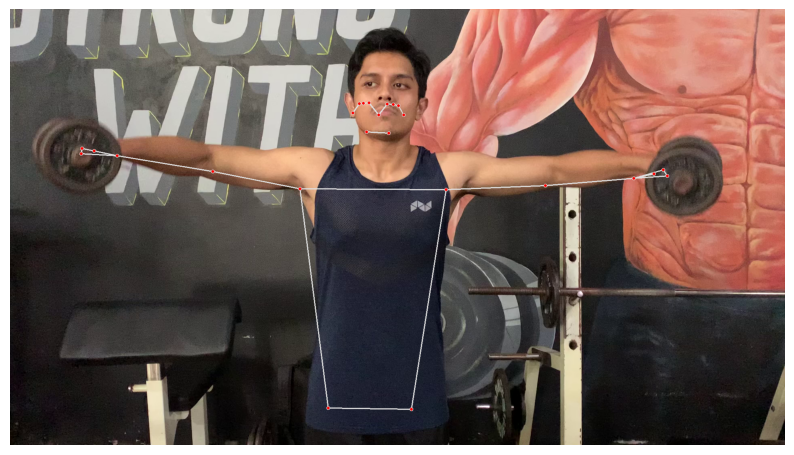

In [7]:
# Open the test video again to display one frame
cap = cv2.VideoCapture(test_video)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # Exit if video ends

    # Convert frame to RGB (MediaPipe requires RGB)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Perform Pose Estimation
    results = pose.process(frame_rgb)

    # Draw the pose landmarks on the frame
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Display the frame with pose landmarks
    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
    plt.axis("off")
    plt.show()

    # Break after displaying one processed frame
    break  

cap.release()